In [1]:
import numpy as np
import random
import traci
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

import matplotlib.pyplot as plt
import math

In [2]:
# SUMO configuration
SUMO_BINARY = "sumo" # "sumo-gui"  # or "sumo"
SUMO_CONFIG = "../config/my_simulation.sumocfg"

# Hyperparameters
GAMMA = 1 #0.99
ALPHA = 0.001   # Learning rate
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

REPLAY_BUFFER_SIZE = 10000      # MEMORY_CAPACITY ????
BATCH_SIZE = 32 #64                 
TARGET_UPDATE = 10   # (frequency) Update target network every N episodes

NBR_EPISODES = 100 #500
STEPS_PER_EPISODE = 1000 #3600  # 1 hour in simulation steps

# Initialize environment parameters
STATE_SIZE = 4 #4  # Adjust based on state representation: e.g., (highway_density, ramp_density, ...)
ACTION_SIZE = 2 #3  # Adjust based on action space: e.g., green light durations

## Neural Network architecture
Continuous state space for DQN

In [3]:
# Neural network architecture
class DQN(nn.Module):
    def __init__(self, state_size, action_size, batch_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, batch_size)
        # self.fc2 = nn.Linear(batch_size, batch_size)
        self.fc3 = nn.Linear(batch_size, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# # Define the Q-network model
# class QNetwork(nn.Module):
#     def __init__(self, state_dim, action_dim):
#         super(QNetwork, self).__init__()
#         self.fc1 = nn.Linear(state_dim, 32)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(32, action_dim)
        
#     def forward(self, state):
#         x = self.fc1(state)
#         x = self.relu(x)
#         x = self.fc2(x)
#         return x

# # Instantiate the Q-network and target Q-network
# model = QNetwork(state_dim=STATE_SIZE, action_dim=ACTION_SIZE)
# target_model = QNetwork(state_dim=STATE_SIZE, action_dim=ACTION_SIZE)

# # Initialize the target model with the weights of the main model
# target_model.load_state_dict(model.state_dict())

# # Optimizer and loss function
# optimizer = optim.Adam(model.parameters(), lr=ALPHA)
# loss_fn = nn.MSELoss()


In [5]:
# Initialize networks and optimizer
policy_net = DQN(STATE_SIZE, ACTION_SIZE, BATCH_SIZE)
target_net = DQN(STATE_SIZE, ACTION_SIZE, BATCH_SIZE)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=ALPHA)
loss_fn = nn.MSELoss()

# Replay buffer
replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)

In [6]:
def get_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    return math.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)

def get_nearest_vehicle_distance(junction_id, edge_id):
    """
    Get the smallest distance between a junction and the nearest vehicle on a specific edge.
    
    Args:
    - junction_id: ID of the junction (e.g., "J11").
    - edge_id: ID of the edge (e.g., "E6").
    
    Returns:
    - Smallest distance to the nearest vehicle or None if no vehicles are on the edge.
    """
    # Get the position of the junction
    junction_position = traci.junction.getPosition(junction_id)
    
    # Get the list of vehicle IDs on the specified edge
    vehicle_ids = traci.edge.getLastStepVehicleIDs(edge_id)
    
    if not vehicle_ids:
        # No vehicles on the edge
        return float('inf')
    
    # Calculate distances from the junction to each vehicle
    distances = []
    for vehicle_id in vehicle_ids:
        vehicle_position = traci.vehicle.getPosition(vehicle_id)
        distance = get_distance(junction_position, vehicle_position)
        distances.append(distance)
    
    # Return the smallest distance
    return min(distances)

In [7]:
# Helper functions
def choose_action(state, epsilon):
    """Epsilon-greedy action selection."""
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, ACTION_SIZE - 1)  # Exploration
    else:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = policy_net(state_tensor)
        return torch.argmax(q_values).item()  # Exploitation
    

def take_action(action):
    """Apply the selected action in SUMO."""
    traci.trafficlight.setPhase("J11", action)
    
    # durations = [10, 20, 30]  # Example action mapping to green light durations
    # traci.trafficlight.setPhaseDuration("J11", durations[action])


def get_state():
    """Retrieve the current state from SUMO."""

    # Cars density
    highway_density = traci.edge.getLastStepVehicleNumber("E6")   #sum(traci.lane.getLastStepVehicleNumber(lane) for lane in ["E6_0", "E6_1", "E6_2"])
    ramp_density = traci.edge.getLastStepVehicleNumber("E8")
    junction_density = traci.edge.getLastStepVehicleNumber(":J11_2")

    # Cars speed
    highway_speed = traci.edge.getLastStepMeanSpeed("E6")   #sum(traci.lane.getLastStepMeanSpeed(lane) for lane in ["E6_0", "E6_1", "E6_2"]) / 3
    ramp_speed = traci.edge.getLastStepMeanSpeed("E8")
    # highway_speed = (traci.edge.getLastStepMeanSpeed("E6") + traci.edge.getLastStepMeanSpeed("E7"))
    # if highway_density > 0 and traci.edge.getLastStepVehicleNumber("E7") > 0:       
    #     highway_speed /= 2                                      # Mean

    # Halting cars
    highway_halts = traci.edge.getLastStepHaltingNumber("E6")
    ramp_halts = traci.edge.getLastStepHaltingNumber("E8")

    # Collisions
    nbr_colliding_vehicles = traci.simulation.getCollidingVehiclesNumber()

    # Emergency stopping cars
    nbr_stopping_vehicles = traci.simulation.getEmergencyStoppingVehiclesNumber()

    # Nearest Distance from highway to TL
    nearest_distance_highway = get_nearest_vehicle_distance("J11", "E6")
    
    
    # state = (junction_density, ramp_density, highway_speed, nearest_distance_highway)
    # state = np.array([highway_density, ramp_density, highway_speed, ramp_speed, nearest_distance_highway, junction_density], dtype=np.float32)


    #######################################################
    state = [
        highway_halts,
        ramp_halts,
        highway_speed,
        # ramp_speed,
        
        highway_density,
        # ramp_density,

        # nearest_distance_highway
    ]
    #######################################################
    
    return state


def calculate_reward(state):
    """Calculate reward based on the current state."""
    # highway_density, ramp_density, highway_speed, ramp_speed = state

    #######################################################
    # Cars density
    highway_density = traci.edge.getLastStepVehicleNumber("E6")   #sum(traci.lane.getLastStepVehicleNumber(lane) for lane in ["E6_0", "E6_1", "E6_2"])
    ramp_density = traci.edge.getLastStepVehicleNumber("E8")
    junction_density = traci.edge.getLastStepVehicleNumber(":J11_2")

    # Cars speed
    highway_speed = traci.edge.getLastStepMeanSpeed("E6")   #sum(traci.lane.getLastStepMeanSpeed(lane) for lane in ["E6_0", "E6_1", "E6_2"]) / 3
    ramp_speed = traci.edge.getLastStepMeanSpeed("E8")
    # highway_speed = (traci.edge.getLastStepMeanSpeed("E6") + traci.edge.getLastStepMeanSpeed("E7"))
    # if highway_density > 0 and traci.edge.getLastStepVehicleNumber("E7") > 0:       
    #     highway_speed /= 2                                      # Mean

    # Halting cars
    highway_halts = traci.edge.getLastStepHaltingNumber("E6")
    ramp_halts = traci.edge.getLastStepHaltingNumber("E8")

    # Collisions
    nbr_colliding_vehicles = traci.simulation.getCollidingVehiclesNumber()

    # Emergency stopping cars
    nbr_stopping_vehicles = traci.simulation.getEmergencyStoppingVehiclesNumber()

    # Nearest Distance from highway to TL
    nearest_distance_highway = get_nearest_vehicle_distance("J11", "E6")


    #######################################################
    # highway_halts = state[0]
    # ramp_halts = state[1]
    # highway_speed = state[2]
    # ramp_speed = state[3]
    # highway_density = state[4]
    # ramp_density = state[5]

    reward = - (highway_halts + ramp_halts) + (highway_speed + ramp_speed)
    # reward = - (highway_halts + ramp_halts + highway_density + ramp_density + nbr_stopping_vehicles) + (highway_speed + ramp_speed) * 0.1 - nbr_colliding_vehicles * 100

    #######################################################

    # reward = - (ramp_density + highway_density)  # Penalize high queue lengths

    ## Get the current traffic light state
    # light_state = traci.trafficlight.getRedYellowGreenState("J11")
    # if "r" in light_state:  # The ramp phase is red             # Check if the phase is red for ramp traffic
    #     reward -= 0.02  # Small penalty for a red light phase (adjust the penalty value as needed)
    
    return reward

In [8]:
def train():
    """Train the DQN using replay buffer."""
    if len(replay_buffer) < BATCH_SIZE:
        return
    
    # Sample mini-batch from replay buffer
    batch = random.sample(replay_buffer, BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32)

    # Q(s, a) and max_a' Q'(s', a')
    q_values = policy_net(states).gather(1, actions).squeeze()
    next_q_values = target_net(next_states).max(1)[0]
    target_q_values = rewards + GAMMA * next_q_values * (1 - dones)

    # Loss and optimization
    loss = loss_fn(q_values, target_q_values.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [9]:
# Main training loop
episode_rewards = [] 
epsilon = 0.1 #EPSILON_START

traci.start([SUMO_BINARY, "-c", SUMO_CONFIG])
for episode in range(NBR_EPISODES):
    # traci.start([SUMO_BINARY, "-c", SUMO_CONFIG])
    state = get_state()
    total_reward = 0
    
    for step in range(STEPS_PER_EPISODE):
        # Choose & Take action A
        action = choose_action(state, epsilon)
        take_action(action)
        traci.simulationStep()
        
        # Observe S' & R
        next_state = get_state()
        reward = calculate_reward(next_state)
        done = (step == STEPS_PER_EPISODE - 1)  # End of episode
        
        # Store transition in replay buffer
        replay_buffer.append((state, action, reward, next_state, done))
        
        # Train the policy network
        train()
        
        state = next_state
        total_reward += reward
    
    # Update epsilon
    # epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    
    
    episode_rewards.append(total_reward)  # Append the total reward for the episode to the list
    

    # Update target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    # traci.close()
    
traci.close()


Episode 1: Total Reward = 9180.29972673872
Episode 2: Total Reward = 19758.20749099614
Episode 3: Total Reward = 20213.094249567468
Episode 4: Total Reward = 19312.122363130544
Episode 5: Total Reward = 19436.087932665927
Episode 6: Total Reward = 19504.137794371236
Episode 7: Total Reward = 19763.441223479196
Episode 8: Total Reward = 19279.98121283261
Episode 9: Total Reward = 19090.702119119538
Episode 10: Total Reward = 19116.970808670423
Episode 11: Total Reward = 19311.573465379653
Episode 12: Total Reward = 19410.359580178694
Episode 13: Total Reward = 19333.416697850495
Episode 14: Total Reward = 18942.079948415423
Episode 15: Total Reward = 17430.72507890373
Episode 16: Total Reward = 19256.155458314293
Episode 17: Total Reward = 19316.70411366303
Episode 18: Total Reward = 19151.470092613738
Episode 19: Total Reward = 19741.297574303793
Episode 20: Total Reward = 19152.04428089273
Episode 21: Total Reward = 19333.901612009027
Episode 22: Total Reward = 19444.88221112317
Episo

KeyboardInterrupt: 

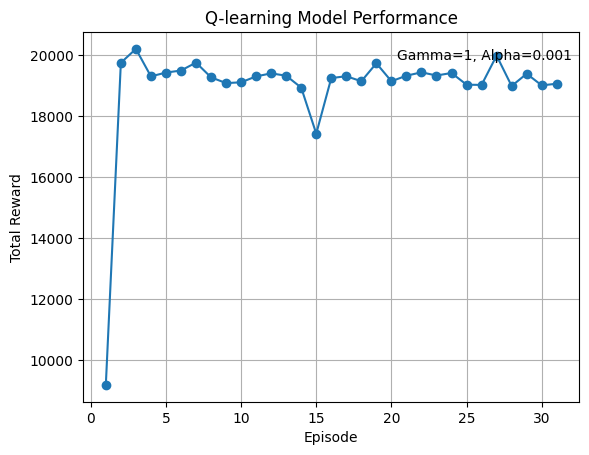

In [10]:
# Plot the episode rewards
nbr_run_episodes = len(episode_rewards) + 1
plt.plot(range(1, nbr_run_episodes), episode_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-learning Model Performance')
plt.grid(True)
# Add a legend with hyperparameter values
hyperparams_text = f'Gamma={GAMMA}, Alpha={ALPHA}'#, Epsilon={EPSILON}'
plt.text(nbr_run_episodes, max(episode_rewards), hyperparams_text, ha='right', va='top', fontsize=10)

plt.show()